In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output')
pos_data_dir  = os.path.join(parent_dir, 'Plotting_tools/shared_data')

In [3]:
positions = pd.read_csv(os.path.join(pos_data_dir, 'rt_positions.csv'))
positions['datetine'] = pd.to_datetime(positions['date'])

In [4]:
positions = positions.loc[positions.groupby('platform_id')['date'].idxmax()]

In [ ]:
last_dates_df.head()

In [6]:
platform_mask = {
        'Ship':  'x',
        'glider': '^',
        'Float':  'o'}

platform_colors = {
        'Discovery':  'black',
        'unit_405': '#b2182b',
        'unit_397':  '#f4a582',
        'unit_398': '#d6604d',
        'unit_345': '#fddbc7',
        'lovuse031c': '#92c5de',
        'lovuse032c': '#4393c3',
        'lovuse026d': '#2166ac'}

def get_color(platform_id):
    return platform_colors.get(platform_id, 'black')

positions['color'] = positions['platform_id'].apply(get_color)


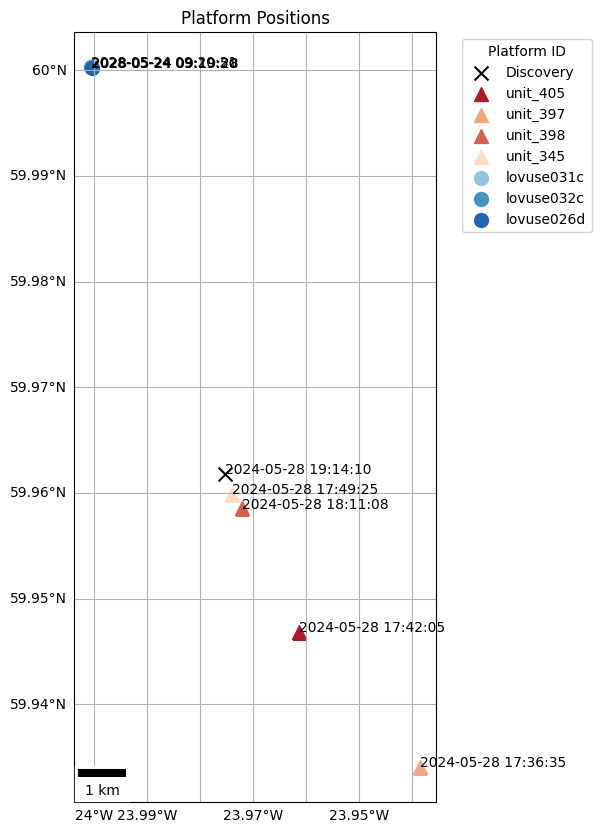

In [28]:


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())

                    # Set the map extent based on your latitude and longitude ranges
#ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())


for platform_type, mask in platform_mask.items():
    subset = positions[positions['platform_type'] == platform_type]
    for platform_id, color in platform_colors.items():
        sub_subset = subset[subset['platform_id'] == platform_id]
        if not sub_subset.empty:
            ax.scatter(sub_subset['lon'], sub_subset['lat'], c=color, label=platform_id, marker=mask, s=100, transform=ccrs.PlateCarree())
            for index, row in sub_subset.iterrows():
                ax.annotate(str(row['date']), (row['lon'], row['lat']), transform=ccrs.PlateCarree())

# Add a scale bar
ax.add_artist(ScaleBar(1, location = "lower left"))

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Platform Positions')

plt.legend(title='Platform ID', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust the coordinates as needed
plt.show()


plt.close()

